# Graph API Readings from Raspberry Pi
This notebook fetches sensor readings from the API and plots them.

Fetching data from: http://localhost:5000/readings
Successfully fetched 57 records.

DataFrame Head:
          sensor_id                        timestamp               type  \
56    PHProbe-Tank1 2025-04-17 20:12:14.505227+00:00                 pH   
55    ECMeter-Tank1 2025-04-17 20:12:14.541445+00:00                 EC   
54  TempProbe-Tank1 2025-04-17 20:12:14.574847+00:00  Water temperature   
53    PHProbe-Tank1 2025-04-17 20:13:14.532575+00:00                 pH   
52    ECMeter-Tank1 2025-04-17 20:13:14.561127+00:00                 EC   

      value  
56     7.00  
55  2000.00  
54    25.01  
53     7.91  
52  1291.91  

Found 3 sensor types: ['pH' 'EC' 'Water temperature']


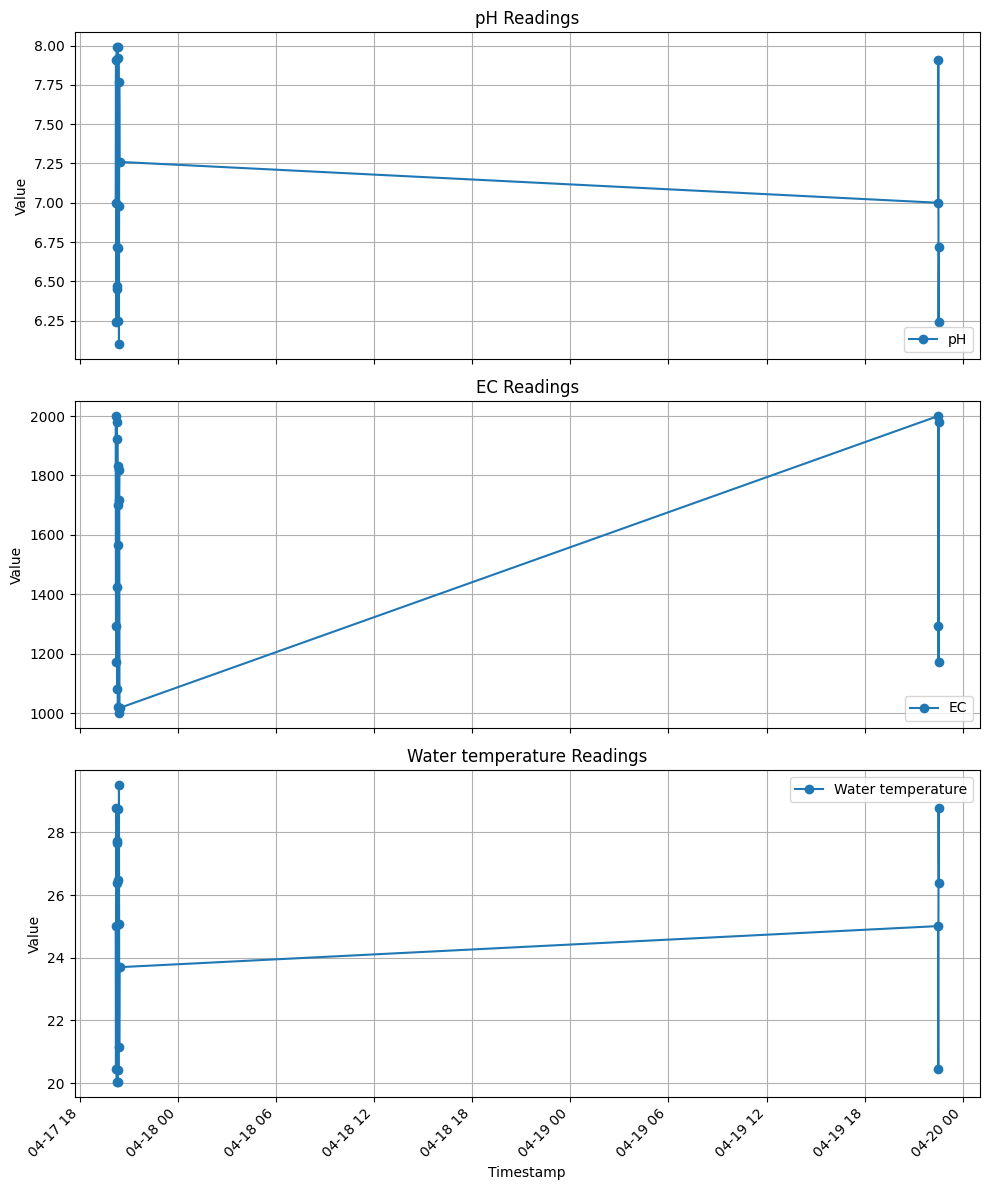

In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy for checking axes type

# Set your API endpoint here
# API_URL = 'http://raspberrypi.middlebury.edu:5000/readings'  # Use this if your Pi is accessible
API_URL = 'http://localhost:5000/readings'  # Use this if running the API locally

try:
    # Fetch the readings
    print(f"Fetching data from: {API_URL}")
    response = requests.get(API_URL, timeout=10) # Added a timeout
    response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
    data = response.json()
    print(f"Successfully fetched {len(data)} records.")

    # --- THIS IS THE BLOCK TO REMOVE OR COMMENT OUT ---
    # # Display the raw JSON (optional) - This dummy data overwrites the API data!
    # data = [
    #     {'sensor_id': 'TempProbe-Tank1', 'timestamp': '2025-04-18T16:27:37.227281+00:00', 'type': 'Water temperature', 'value': 20.05},
    #     {'sensor_id': 'ECMeter-Tank1', 'timestamp': '2025-04-18T16:27:37.186311+00:00', 'type': 'EC', 'value': 1425.91},
    #     {'sensor_id': 'PHProbe-Tank1', 'timestamp': '2025-04-18T16:27:37.158227+00:00', 'type': 'pH', 'value': 7.99},
    #     {'sensor_id': 'TempProbe-Tank1', 'timestamp': '2025-04-18T16:26:37.200133+00:00', 'type': 'Water temperature', 'value': 26.39},
    #     {'sensor_id': 'ECMeter-Tank1', 'timestamp': '2025-04-18T16:26:37.155195+00:00', 'type': 'EC', 'value': 1980.34},
    #     {'sensor_id': 'PHProbe-Tank1', 'timestamp': '2025-04-18T16:26:37.130182+00:00', 'type': 'pH', 'value': 6.72},
    #     {'sensor_id': 'TempProbe-Tank1', 'timestamp': '2025-04-18T16:25:37.168194+00:00', 'type': 'Water temperature', 'value': 28.78},
    #     {'sensor_id': 'ECMeter-Tank1', 'timestamp': '2025-04-18T16:25:37.127254+00:00', 'type': 'EC', 'value': 1173.53},
    #     {'sensor_id': 'PHProbe-Tank1', 'timestamp': '2025-04-18T16:25:37.099105+00:00', 'type': 'pH', 'value': 6.24},
    #     {'sensor_id': 'TempProbe-Tank1', 'timestamp': '2025-04-18T16:24:37.141312+00:00', 'type': 'Water temperature', 'value': 20.45},
    #     {'sensor_id': 'ECMeter-Tank1', 'timestamp': '2025-04-18T16:24:37.096342+00:00', 'type': 'EC', 'value': 1291.91},
    # ]
    # ----------------------------------------------------

    if not data:
        print("No data received from API or data is empty.")
    else:
        # Convert to DataFrame (adjust based on your API's JSON structure)
        df = pd.DataFrame(data)

        # Ensure required columns exist
        required_cols = ['timestamp', 'type', 'value']
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"API response missing one or more required columns: {required_cols}. Found columns: {df.columns.tolist()}")

        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp')
        print("\nDataFrame Head:")
        print(df.head())

        # Get unique sensor types
        sensor_types = df['type'].unique()
        num_types = len(sensor_types)
        print(f"\nFound {num_types} sensor types: {sensor_types}")

        if num_types > 0:
            # Create subplots: one row per sensor type, shared x-axis
            # Make figsize height dynamic
            fig, axes = plt.subplots(nrows=num_types, ncols=1, figsize=(10, 4 * num_types), sharex=True, squeeze=False)
            # squeeze=False ensures axes is always a 2D array, even if nrows=1 or ncols=1

            # Flatten axes array for easy iteration
            axes = axes.flatten()

            for i, sensor_type in enumerate(sensor_types):
                ax = axes[i] # Select the appropriate subplot axis
                sensor_df = df[df['type'] == sensor_type].copy() # Use .copy() to avoid SettingWithCopyWarning

                # Optional: Convert value to numeric if needed, coercing errors
                sensor_df['value'] = pd.to_numeric(sensor_df['value'], errors='coerce')
                sensor_df.dropna(subset=['value'], inplace=True) # Drop rows where conversion failed

                if not sensor_df.empty:
                    ax.plot(sensor_df['timestamp'], sensor_df['value'], marker='o', linestyle='-', label=sensor_type)
                    ax.set_ylabel('Value')
                    ax.set_title(f'{sensor_type} Readings')
                    ax.legend()
                    ax.grid(True)
                else:
                    ax.set_title(f'{sensor_type} Readings (No valid data)')
                    ax.text(0.5, 0.5, 'No valid data points', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


            # Common X-axis label and rotation for the last plot
            axes[-1].set_xlabel('Timestamp')
            plt.xticks(rotation=45, ha='right') # Use ha='right' for better alignment
            plt.tight_layout() # Adjust layout to prevent overlap
            plt.show()
        else:
            print("No sensor types found in the data to plot.")

except requests.exceptions.RequestException as e:
    print(f"Error fetching data from API: {e}")
except ValueError as e:
    print(f"Data processing error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")